# Imports

In [3]:
# %matplotlib widget

import os
import sys
import subprocess

import torch
import torchaudio
import umap
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchaudio.transforms import MelSpectrogram, MFCC
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.ndimage

In [4]:
from utility_data import *
from utility_plots import *

# Loading Data

- `train_audio/`: short recordings of individual species with labels - *supervised learning*
- `train_soundscapes/`: long recordings without labels - *unsupervised learning*
- `train.csv`: metadata for the training audio


## Dataset Interaction

In [5]:
# DEFINE TRANSFORM
sample_rate = 32000

mel = MelSpectrogram(sample_rate=sample_rate, n_mels=64)
mfcc = MFCC(sample_rate=sample_rate, n_mfcc=64)

/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [4]:
# INITIALIZE TRAIN_AUDIO DATASET & DATALOADER
ta_dataset = AudioDataset(transform=mel, metadata=True)
ta_dataloader = DataLoader(ta_dataset, batch_size=16, shuffle=True, num_workers=0)

# DEFINE TRAIN_AUDIO METADATA
ta_metadata = ta_dataset.data.iloc[:, -6:]

# INITIALIZE TRAIN_SOUNDSCAPES DATASET & DATALOADER
ts_dataset = AudioDataset(metadata_csv="", audio_dir="train_soundscapes", transform=mel, metadata=True)
ts_dataloader = DataLoader(ts_dataset, batch_size=16, shuffle=True, num_workers=0)

# DEFINE TRAIN_SOUNDSCAPES METADATA
ts_metadata = ts_dataset.data.iloc[:, 2:]

# SAVE DATASETS
ta_dataset.data.to_csv("data/ta_dataset.df")
ts_dataset.data.to_csv("data/ts_dataset.df")

## Frequency of labels

In [5]:
data = ta_dataset.data

Text(0.5, 1.0, 'Frequency of primary_label')

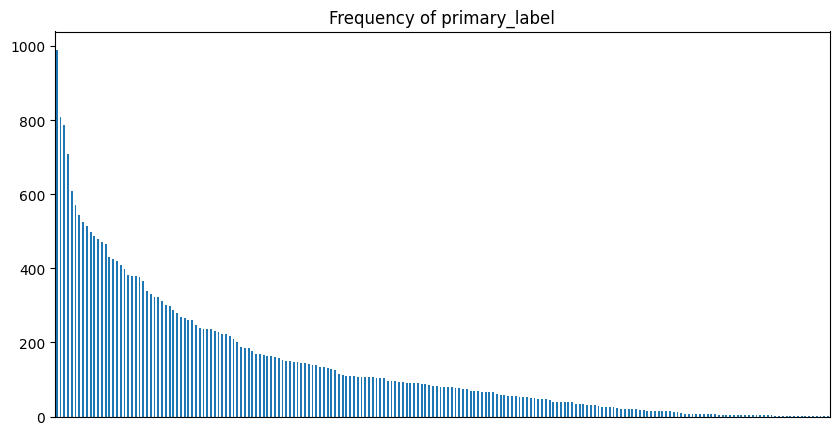

In [6]:
ax = data["primary_label"].value_counts().sort_values(ascending=False).plot(figsize=(10,5), kind='bar')
ax.get_xaxis().set_visible(False)
ax.set_title("Frequency of primary_label")

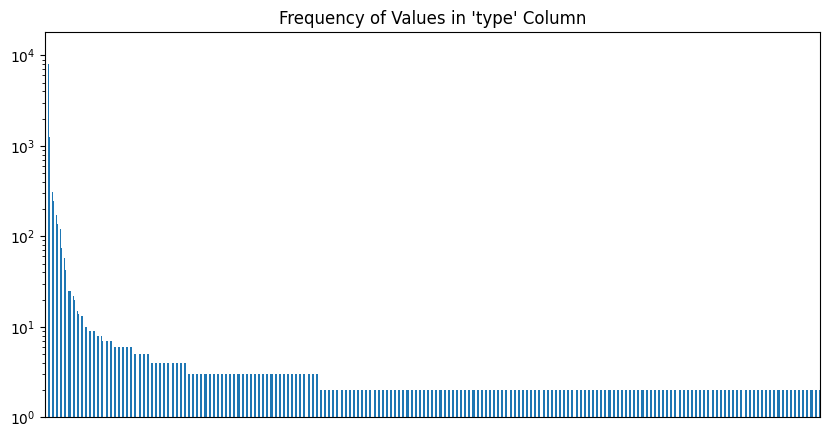

In [7]:
count_data = count_values_in_lists(data, "type")

fig, ax = plt.subplots(figsize=(10,5))
count_data.plot(kind='bar', ax=ax, log=True)
ax.get_xaxis().set_visible(False)
ax.set_title("Frequency of Values in 'type' Column")

plt.show()

In [8]:
primary_labels = data["primary_label"].unique()
summary = pd.DataFrame(primary_labels, columns=["primary_label"])

count_data = []

for col in primary_labels:
    counts_dict = dict(count_values_in_lists(data[data["primary_label"] == col], "secondary_labels"))
    count_data.append({"primary_label": col, **counts_dict})

count_df = pd.DataFrame(count_data)
summary = pd.merge(summary, count_df, on="primary_label", how="left", validate="one_to_one")

summary = summary.fillna(0)
summary = summary.rename(columns={'':'empty'})

summary['sum_values'] = summary.iloc[:, 1:].sum(axis=1)
summary = summary.sort_values(by='sum_values', ascending=False)

numeric_data = summary.iloc[:, 1:-1]
numeric_data.index = summary["primary_label"]

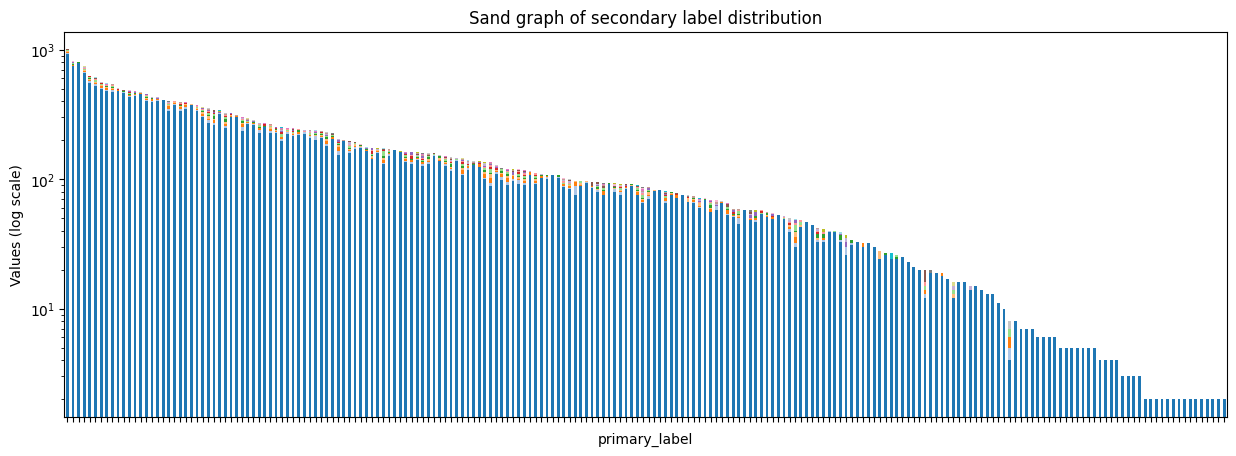

In [9]:
sand_plot(numeric_data, "Sand graph of secondary label distribution")

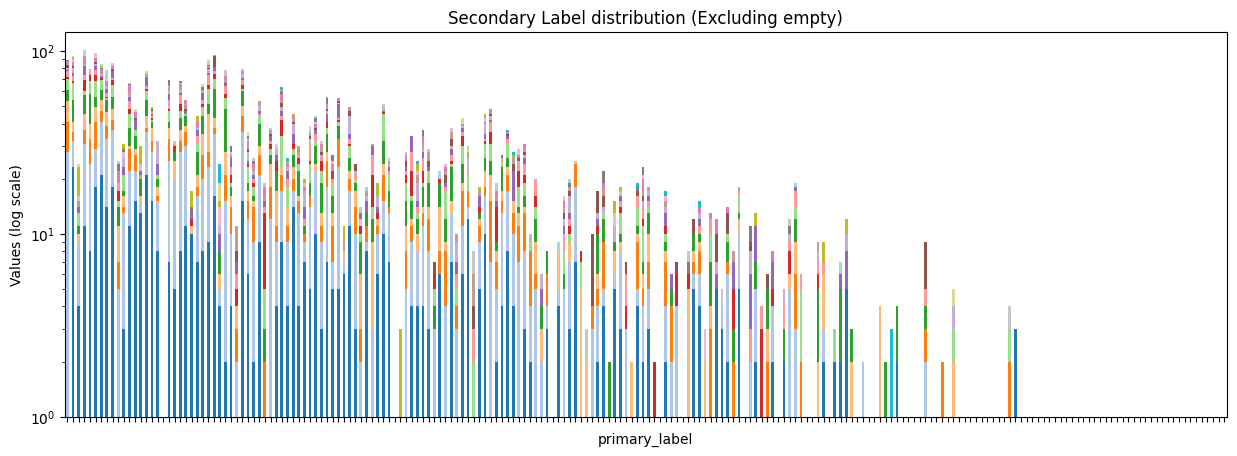

In [10]:
numeric_data = numeric_data.drop('empty', axis=1)
sand_plot(numeric_data, "Secondary Label distribution (Excluding empty)")

## Duration Value Counts

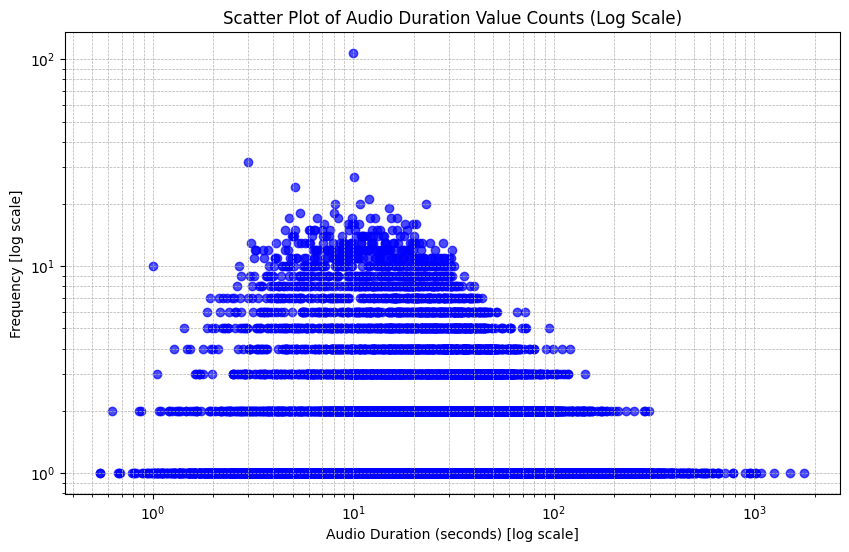

In [11]:
plot_value_counts(ta_metadata["audio_duration"])

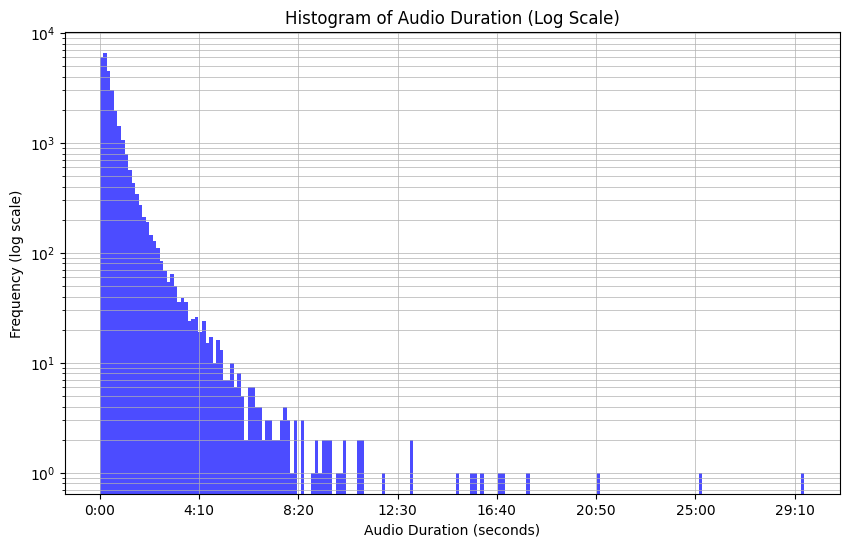

In [12]:
plot_value_histograms(ta_metadata["audio_duration"])

In [13]:
seconds = 30

# percentage of rows with audio_duration less
perc = (ta_dataset.data["audio_duration"] < seconds).mean() * 100
print(f'{perc:.2f}% of recordings are shorter than {seconds}')

63.83% of recordings are shorter than 30


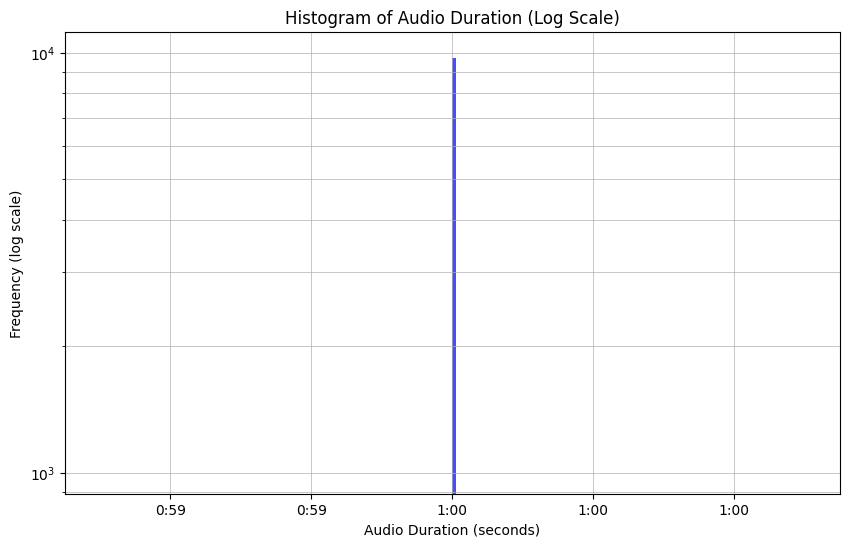

In [14]:
plot_value_histograms(ts_metadata["audio_duration"], 200)

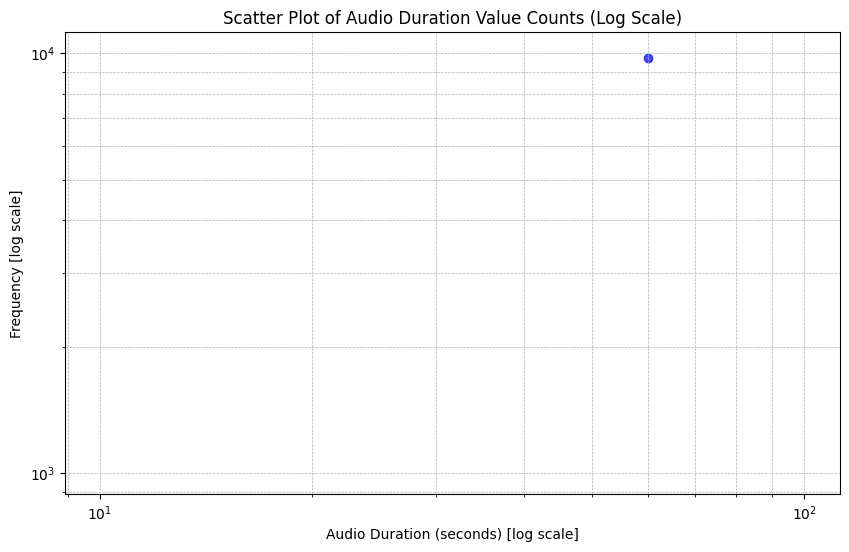

In [15]:
plot_value_counts(ts_metadata["audio_duration"])

### Audio Sampling

In [16]:
def print_unique(data: pd.DataFrame):
    for col in data.columns:
        print(col, "has unique values:", data[col].unique())
        
print_unique(ta_metadata[ta_metadata.columns[2:]])

audio_bitrate has unique values: [72]
audio_sample_rate has unique values: [32000]
audio_channels has unique values: [1]
audio_codec has unique values: ['audio/vorbis']


In [17]:
print_unique(ts_metadata[ts_metadata.columns[2:]])

audio_bitrate has unique values: [72]
audio_sample_rate has unique values: [32000]
audio_channels has unique values: [1]
audio_codec has unique values: ['audio/vorbis']


## Spectrograms

In [18]:
ta_dataset.data

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,file_size,audio_duration,audio_bitrate,audio_sample_rate,audio_channels,audio_codec
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,770871,98.853375,72,32000,1,audio/vorbis
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,755101,96.537719,72,32000,1,audio/vorbis
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,902788,116.599812,72,32000,1,audio/vorbis
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,823062,105.446313,72,32000,1,audio/vorbis
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,814484,103.631469,72,32000,1,audio/vorbis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0,29598,3.392000,72,32000,1,audio/vorbis
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0,61987,7.659688,72,32000,1,audio/vorbis
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0,63164,7.666656,72,32000,1,audio/vorbis
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0,197867,27.036750,72,32000,1,audio/vorbis


In [ ]:
def run_clustering(
    data: pd.DataFrame,
    method: str = 'kmeans',
    n_clusters: int = 3,
    **kwargs
) -> pd.Series:
    """
    Run clustering on a DataFrame and return a Series of cluster labels.
    
    Parameters:
        data (pd.DataFrame): The input features.
        method (str): Clustering method - 'kmeans', 'dbscan', or 'agglomerative'.
        n_clusters (int): Number of clusters (ignored for DBSCAN).
        **kwargs: Additional parameters to pass to the clustering algorithm.
    
    Returns:
        pd.Series: Cluster labels indexed the same as the input DataFrame.
    """
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, **kwargs)
    elif method == 'dbscan':
        model = DBSCAN(**kwargs)
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters, **kwargs)
    else:
        raise ValueError(f"Unsupported clustering method: {method}")
    
    data["index"] = data.index.astype('float64')
    data.columns = data.columns.astype(str)

    data_scaled = StandardScaler().fit_transform(data)

    labels = model.fit_predict(data_scaled)
    return pd.Series(labels, index=data.index, name='cluster')

source = dataset
index = 12

waveform, label = source[index]
df = pd.DataFrame(waveform.squeeze(0).detach().numpy()).T
smoothed_df = pd.DataFrame(scipy.ndimage.median_filter(df, size=(20, 1)))
print(df.shape)

cl = run_clustering(smoothed_df, 'agglomerative', n_clusters=4)
spectrogram(source, index, cl)

Error loading data/train_audio/126247/iNat320679.ogg
(1, 16000)


ValueError: Found array with 1 sample(s) (shape=(1, 16001)) while a minimum of 2 is required by AgglomerativeClustering.

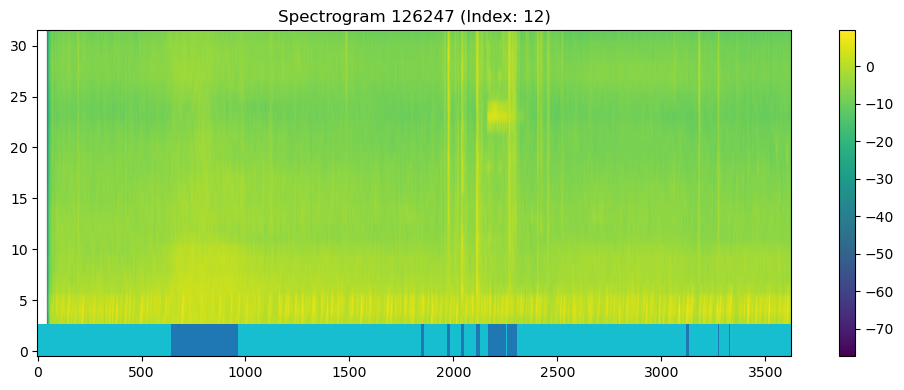

In [ ]:
cl = run_clustering(smoothed_df, 'dbscan', eps=3, min_samples=200)
spectrogram(source, index, cl)

(9601, 32)


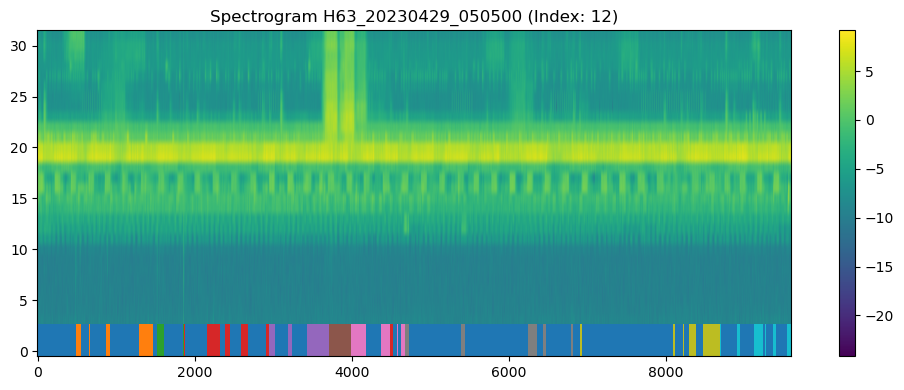

In [ ]:
index = 12

waveform_scape, label_scape = scape[index]
df_scape = pd.DataFrame(waveform_scape.squeeze(0).detach().numpy()).T
smoothed_df_scape = pd.DataFrame(scipy.ndimage.median_filter(df_scape, size=(20, 1)))
print(df_scape.shape)

cl_scape = run_clustering(smoothed_df_scape, 'dbscan', eps=2.05, min_samples=1)
spectrogram(scape, index, cl_scape)

## Outlier Removal

In [ ]:
# remove rows where any column has a value which is an outlier by >3 STD over the column
k = 4
df_means = df.mean()
df_std_devs = df.std()
outliers = ((df - df_means).abs() > (k * df_std_devs)).any(axis=1)

# Remove rows with any outliers
df = df[~outliers]
print(outliers.sum(), "outliers are excluded")

306 outliers are excluded


## Basic Graphs

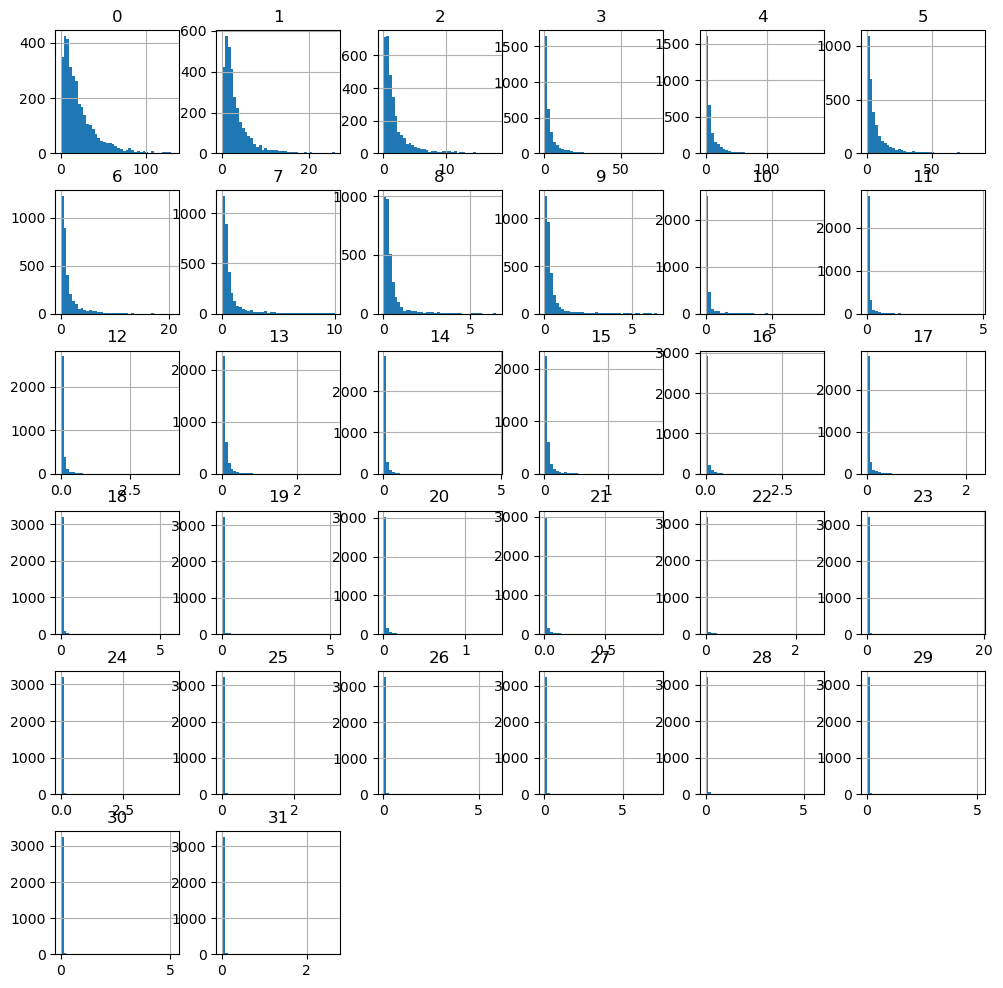

In [ ]:
fig = df.hist(figsize=(12, 12), bins=40)

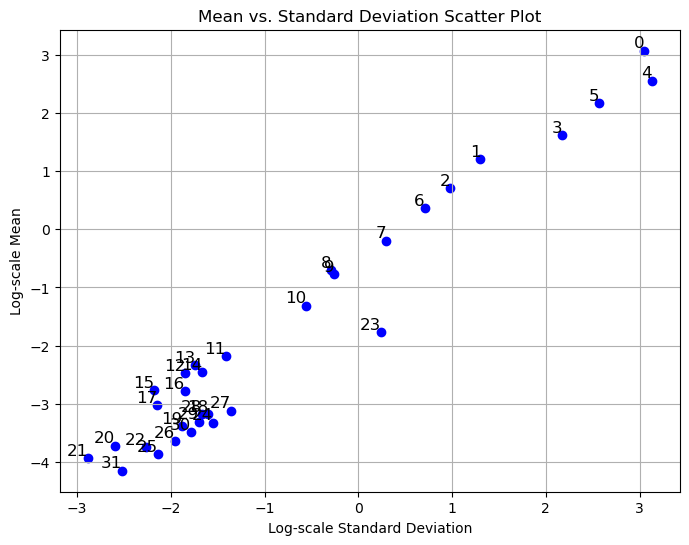

In [ ]:
def plot_mean_std(df: pd.DataFrame, log_map=False):
    """Computes the mean and standard deviation for each column
    and plots the two in a scatterplot with labelled axes"""
    means = df.mean()
    std_devs = df.std()
    
    if log_map:
        epsilon = 0.005
        means = np.log(means.abs() + epsilon)
        std_devs = np.log(std_devs + epsilon)

    plt.figure(figsize=(8, 6))
    plt.scatter(std_devs, means, color='b')
    
    for col in df.columns:
        plt.text(std_devs[col], means[col], col, fontsize=12, ha='right', va='bottom')

    plt.ylabel("Log-scale Mean" if log_map else "Mean")
    plt.xlabel("Log-scale Standard Deviation" if log_map else "Standard Deviation")
    plt.title("Mean vs. Standard Deviation Scatter Plot")
    plt.grid(True)

    # Show plot
    plt.show()


plot_mean_std(df[df.columns], True)


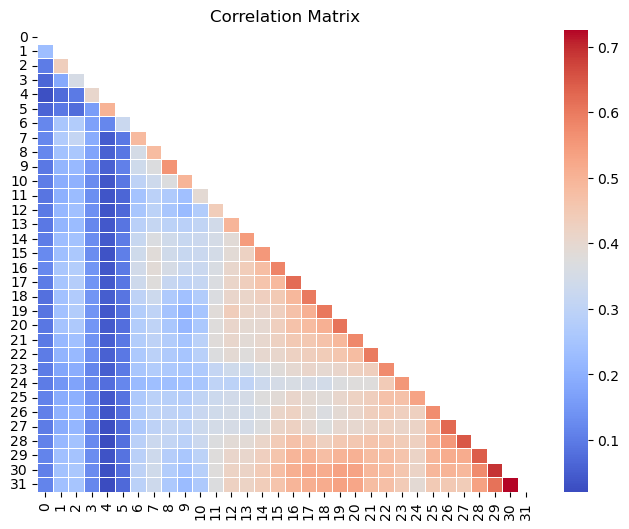

In [ ]:
import seaborn as sns

corr_matrix = df.corr(method='kendall')

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, mask=mask, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Dimensionality Reduction

In [ ]:
scaled_df = StandardScaler().fit_transform(df)

reducer = umap.UMAP(
    n_neighbors=200,
    min_dist=0.1,
    n_components=3,
    metric='chebyshev'
)
embedding = reducer.fit_transform(scaled_df)
embedding.shape

/usr/local/Caskroom/miniconda/base/envs/birdCLEF/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(3321, 3)

In [ ]:
cl_filtered = cl[df.index]
print(len(cl_filtered))
cl_filtered.unique()

3321


array([ 0, -1])

Text(0.5, 1.0, 'UMAP projection of the dataset')

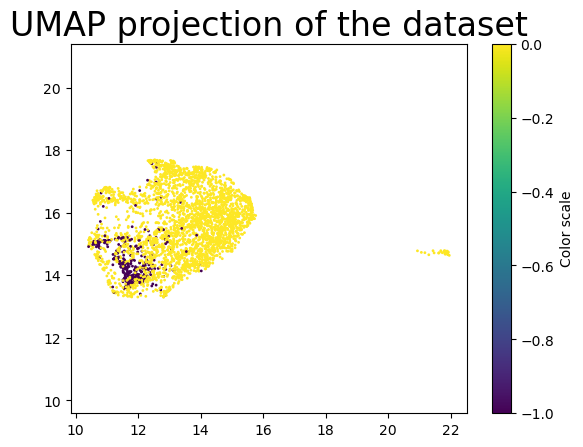

In [ ]:
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1], 
    s=1, 
    c=cl_filtered)

cbar = plt.colorbar(scatter)
cbar.set_label("Color scale")  

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24)

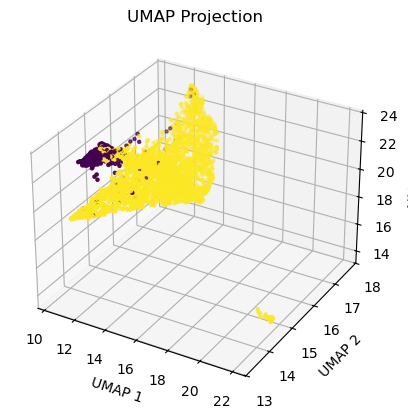

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=cl_filtered, s=5)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP Projection')
plt.show()